In [1]:
## %%# General
import warnings
warnings.filterwarnings ( "ignore" )
import os
from time import time
from datetime import datetime,timedelta  #time,
import matplotlib.pyplot as plt
import multiprocess as mp
from IPython.display import display

# Scientific and data
import json
import yaml
import numpy as np
from tqdm import tqdm
import pandas as pd
import  xarray as xr
from scipy.ndimage import gaussian_filter1d, gaussian_filter
from scipy.interpolate import griddata
from functools import partial
eps = np.finfo(np.float).eps

# pytorch
import torch , torchvision
import torch.utils.data
import torch.nn as nn
from torch import functional as F
from torch import Tensor
torch.manual_seed(8318)


# Local modules
import  global_settings as gs
import data_loader as dl
import preprocessing as prep
from utils import create_and_configer_logger
from miscLidar import calc_tau,calc_extiction_klett, calc_gauss_curve,generate_poisson_signal, generate_poisson_signal_STEP

plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
import seaborn as sns
sns.set(rc={"figure.dpi":300, 'savefig.dpi':300})
#sns.set_context('notebook')

## Load extended calibration database

In [2]:
station_name = 'haifa'
station = gs.Station ( stations_csv_path = 'stations.csv' , station_name = station_name )
# print(station)
start_date = datetime ( 2017 , 9 , 1 )
end_date = datetime ( 2017 , 10 , 31 )
ds_path_extended = f"dataset_{station_name}_{start_date.strftime ( '%Y-%m-%d' )}_{end_date.strftime ( '%Y-%m-%d' )}_extended.nc"
csv_path_extended = f"dataset_{station_name}_{start_date.strftime ( '%Y-%m-%d' )}_{end_date.strftime ( '%Y-%m-%d' )}_extended.csv"
df = pd.read_csv ( csv_path_extended )
ds_extended = prep.load_dataset ( ds_path_extended)
wavelengths = [355,532,1064]

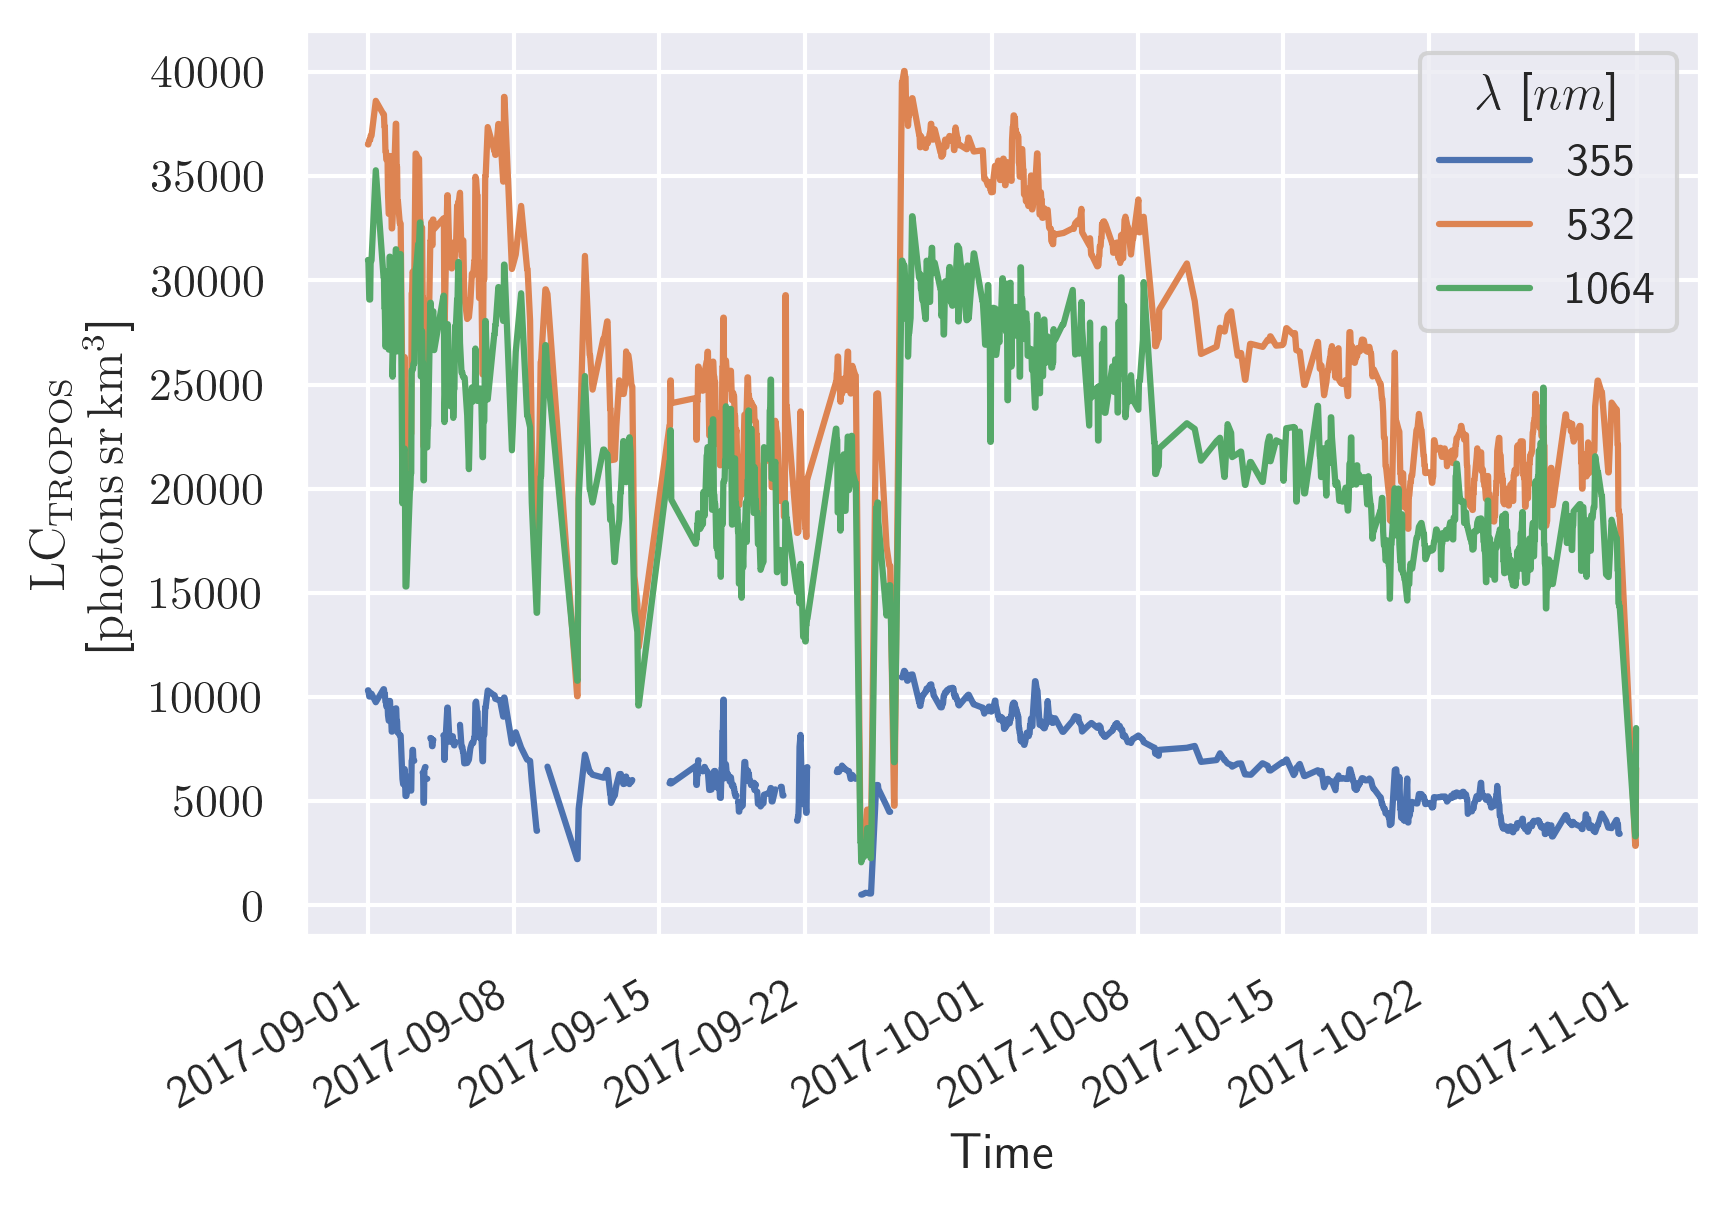

In [3]:
#ds_extended.LC.attrs['long_name'] = r'$\rm{ LC_{TROPOS}}$'
#ds_extended.LC.attrs['units'] = r'$\rm{photons\,sr\,km^3}$'
ds_extended.LC.plot(hue='Wavelength')
plt.show()

### Creating pattern of laser power through days
#### 1. The lidar factor is dependent on optical and geometrical values of the system.
#### 2. From the LC retrieved by TROPOS it seems as it has an exponential decay through the period.
#### 3. Therefore, first generating decay power $p(t)=p_0\cdot\exp(-\frac{t-t_0}{t_{decay}})$
#### 4. Then calculating upper and lower bounding curves of interval of confidence. The interval of confidence is  set as $[\pm5\%,\pm25\% ]$. Higher confidence is for higher power values (meaning small interval of confidence).
#### 4. Then the new power is randomly generated withing the interval of confidence per time %t%

In [311]:
time_indx = pd.date_range(start = start_date, end = end_date,freq = '3H')
df_times = pd.DataFrame(time_indx,columns = ['date'])
bins_per_day = timedelta(days = 1)/pd.to_timedelta(time_indx.freq)
df_times['t_day']=(df_times.index/bins_per_day).values


days_decay = 70

def decay_p (t,t0,p0):
	return p0*(np.exp(-(t-t0)/days_decay))

def var_p(p,maxv,minv):
	return 0.25*(1-p/(maxv))/((maxv-minv)/maxv)+0.05*(1-(1-ds_gen_p.p/(maxv))/((maxv-minv)/maxv))

peak_days = np.array([-10,40])
period1 = (df_times.t_day>=peak_days[0]) & (df_times.t_day<peak_days[1])
period2 = (df_times.t_day>=peak_days[1])

# %%
ds_chans = []
for wavelength,p0 in zip(wavelengths,[15000,45000,35000]):
	c1 = df_times[period1].apply(lambda row: decay_p(row.t_day,peak_days[0],p0), axis = 1 ,result_type = 'expand')
	c2 = df_times[period2].apply(lambda row: decay_p(row.t_day,peak_days[1],p0), axis = 1 ,result_type = 'expand')
	ds_chans.append(xr.Dataset (
    data_vars = {'p' : (('Time') , pd.concat([c1,c2])) ,
                 'lambda_nm' : ('Wavelength' , np.uint16 ( [ wavelength ] ))
                 } ,
    coords = {'Time' : df_times.date.values ,
              'Wavelength' : np.uint16 ( [ wavelength ] )
                  }))


# %%
ds_gen_p = xr.concat ( ds_chans , dim = 'Wavelength' )
ds_gen_p.p.attrs = {'units' : r'$\rm{photons\,sr\,km^3}$' , 'long_name' : r'$\rm{ LC_{generated}}$' ,
                           'info' : 'LC - Lidar constant - from generation'}

# %%
ds_gen_p =\
	ds_gen_p.assign(
	p_ubound =
xr.apply_ufunc(lambda p,maxv,minv: p+p*var_p(p,maxv,minv),
               ds_gen_p.p,ds_gen_p.p.max(dim='Time'),
               ds_gen_p.p.min(dim='Time'), keep_attrs = True),#.plot(hue='Wavelength')
	p_lbound =
xr.apply_ufunc(lambda p,maxv,minv: p-p*var_p(p,maxv,minv),
               ds_gen_p.p,ds_gen_p.p.max(dim='Time'),
               ds_gen_p.p.min(dim='Time'), keep_attrs = True))#.plot(hue='Wavelength')

ds_gen_p = ds_gen_p.assign( p_new = xr.apply_ufunc(lambda lbound,ubound,rand: lbound+ (ubound-lbound)*rand,
               ds_gen_p.p_lbound,ds_gen_p.p_ubound,np.random.rand(3,ds_gen_p.Time.size),keep_attrs = True))

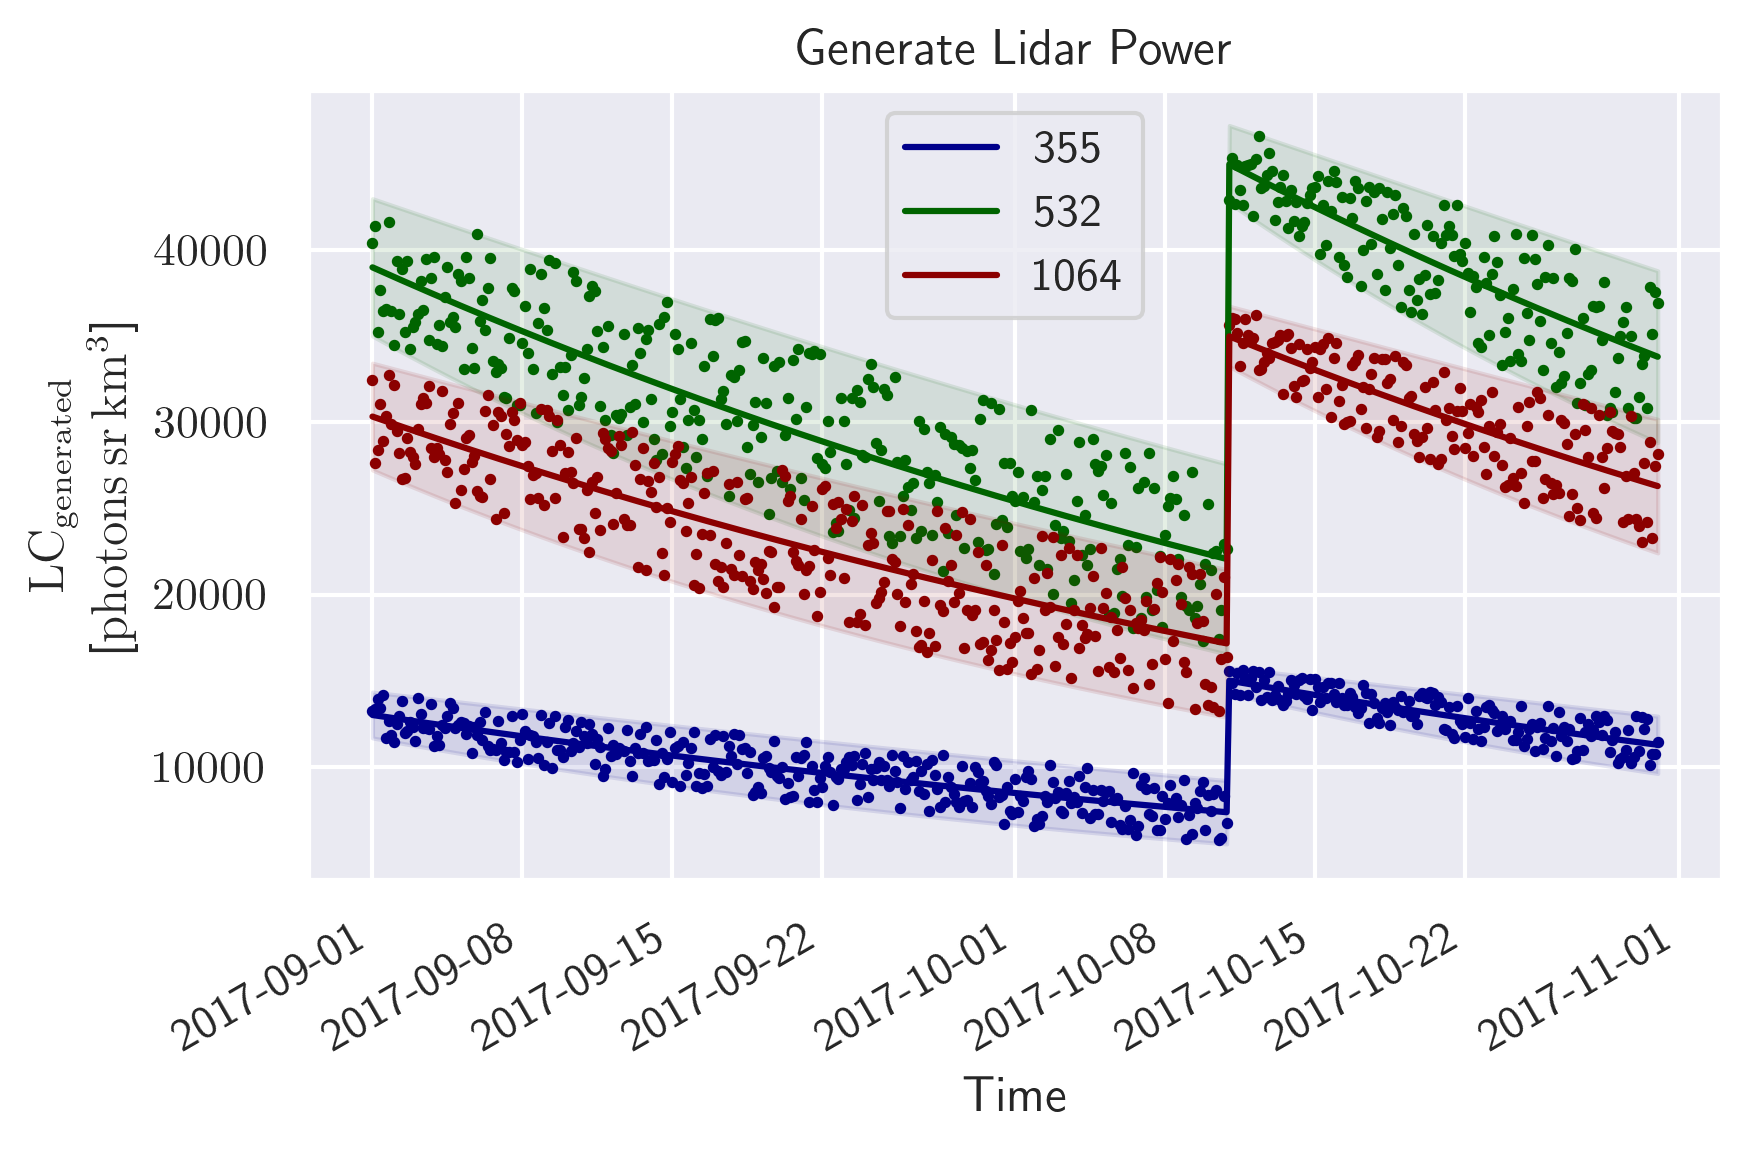

In [312]:
for wavelength,c in zip(wavelengths,['darkblue','darkgreen','darkred']):
	ds_gen_p.sel(Wavelength=wavelength).plot.scatter(y='p_new',x='Time',s=3,color=c)
	ds_gen_p.p.sel(Wavelength= wavelength).plot(color=c,label=wavelength)
	plt.fill_between(ds_gen_p.Time.values,
	                 ds_gen_p.p_lbound.sel(Wavelength= wavelength).values,
	                 ds_gen_p.p_ubound.sel(Wavelength=wavelength).values,
	                 color=c, alpha=.1)
plt.title('Generate Lidar Power')
plt.legend()
plt.tight_layout()
plt.show()